In [1]:
import pandas as pd
from pandas_datareader import data as dt

import matplotlib.pyplot as plt
from matplotlib import lines

from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr

import math
import datetime
import quandl
import random as rnd

import numpy as np
from numpy import random as nprnd

In [2]:
#Создание сгенерированных данных из смеси распределения Нормального и Стьюдента. На вход функции подаются N,n, E-мат.ожидание
#D-будет играть роль "дисперсии" т.е. ковариационная матрица  ni-количество степеней свободы
#Распределение Гаусса генерируется встроенной функцией, Стюдента генерируем сами функцией get_t,но в данном случае используется 
#встроенная функция nprnd.gamma которая как раз генерирует необходиым для нас данны,на вход принимает кол-во степеней свободы
#деленное на 2
def get_art_data(N, g, E, D, n=250, ni=3):
    Ver = []
    for i in range(N):
        X = []
        for j in range(n):
            if rnd.random() >= g:
                x = rnd.gauss(E[i],D[i])
            else:
                x = rnd.gauss(E[i],D[i]) / np.sqrt(nprnd.gamma(ni/2,ni/2))
                #x = get_t([rnd.gauss(0,1) for i in range(ni+1)])
            X.append(x)
        Ver.append(X)
    return Ver

In [3]:
#Математическое ожидание,которое находится как среднее,т.е. сумма деленная на количество
#
#
#
#
def E(sample):
    return round(sum(sample)/len(sample), 4) 

In [4]:
#Выгрузка данных с сайта quandl wiki ,непонятные слова, это личный пароль доступа к данным,т.к. они в закрытом виде
#
#
#
#
def get_data(tickers, start_date, end_date):
    #qbxG_EyRzFshVRHk8Ryi
    quandl.ApiConfig.api_key = '8E4Ex9CHKmr7MF3H5yYz'
    data = quandl.get_table('WIKI/PRICES', ticker = tickers,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': start_date, 'lte': end_date }, paginate=True)
    clean = data.set_index('ticker')
    table = clean.pivot(columns='date')

    return table

In [5]:
#Функция удаления пустых элементов(формально звучит так). Реально же, идет проверка данных по датам и там где пустые, заменяются
#средними данными по соседям
#
#
#
def remove_empty_fields(data):
    shape = data.shape
    for comp in range(shape[0]):
        for day in range(shape[1]):
            if math.isnan(data[comp][day]):
                data[comp][day] = data[comp][(day - 1)%shape[1]]

In [6]:
# Функция знаковой корреляции
#
#
#
#
def signDep(X, Y):
    count=0
    if(len(X)!=len(Y)):return
    n=len(X)
    for i in range(n):
        if ( np.sign(X[i] - E(X)) == np.sign(Y[i]-E(Y) ) ):
            count+=1
        else: count-=1
    res=float(count)/n
    return res

In [7]:
# Встроенная функция Пирсоновской корреляции
##
##
##
#
def pr_corr(X, Y):
    return pearsonr(X,Y)[0]

In [8]:
# Встроенная  функия для нахождения p-value
##
##
##
#
def get_p_value(X,Y):
    return pearsonr(X,Y)[1]

In [9]:
# Встроенная функия для нахождения корреляции Спирмена
##
##
##
#
def sp_corr(X, Y):
    return spearmanr(X,Y)[0]

In [10]:
#  Функция для генерированния данных по определенным правилам, например можно подать данные и функцию корреляции и получим
## корреляцию между данными
##
##
#
def gen_net(data, f):
    N = len(data)
    net = [ [round(f(data[i], data[j]), 4) for j in range(N)] for i in range(N)]
    return net

In [11]:
#  Функция генерации данных графа по заданному пороговому значения и матрице смежности
##
##
##
#
def gen_graph(net, treshold):
    N = len(net)
    graph = [ [(net[i][j] >= treshold) for j in range(N)] for i in range(N) ]
    return graph

In [12]:
#  Функция создания координат вершин графа 
##
##
##
#
def coord(N):
    angles = [math.radians(n*360.0/N) for n in range(N)]
    coords = [(round(math.cos(a),4), round(math.sin(a),4)) for a in angles]
    return coords

In [13]:
#  Функция визуализации графа
##
##
##
#
def plot_graph(graph, tickers):
    coords = coord(len(graph) )
    lim = 1.2
    plt.axis([-lim, lim, -lim, lim])

    for i,c in enumerate(coords):
        plt.plot(c[0], c[1], 'bo')
        dash = 1
        if (c[0] <= 0):
            dash = 1.2
        plt.text(s=tickers[i], x=dash*c[0], y=1.1*c[1])


    for i,c1 in enumerate(coords):
        for j,c2 in enumerate(coords):
            if ( (not i == j) and (graph[i][j]) ):
                plt.plot( (c1[0],c2[0]),(c1[1],c2[1]),'g-')

    plt.show()

In [14]:
# Функцая меры схожести графов основанная на F-мере
##
##
##
#
def meassure_of_graph_similarity(G1,G2,B=1):
    n = len(G1)
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    for i in range(n):
        for j in range(n):
            if i==j: continue
            x = G1[i][j]
            y = G2[i][j]
            if x and y:
                TP+=1
            if not x and not y:
                TN+=1
            if not x and y:
                FN+=1
            if x and not y:
                FP+=1
    if TP == 0: return 0
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    F = (1+B)*(prec*rec)/( (B**2)*prec+rec)            
    return F

In [15]:
#  Функция возвращающая по входным данных бинарную матрицу для построение MST основана на Приме
##
##
##
#
def MST(W):
    N = len(W)
    INF = 10 ** 9
    MST = []

    used = [0]
    for i in range(N-1): 
        max_dist = -1
        for current in used:
            for j in range(N):
                if W[current][j] > max_dist and not j in used:
                    max_dist = W[current][j]
                    u = j
                    c = current
        used.append(u)
        MST.append((c,u))
     
    res = np.zeros((N,N))
    
    for edge in MST:
        res[edge[0]][edge[1]] = 1
        res[edge[1]][edge[0]] = 1
    return res

In [16]:
# Функция генерации распределения Стьюдента
##
##
##
#
def get_t(Y):
    n = len(Y)
    sqws = [Y[i]**2 for i in range(1,n-1)]
    t = Y[0]/pow( (1.0/n)*sum(sqws),1.0/2)
    return t

In [17]:
# Функция реализации процедуры Холма
##Константа С каждый раз высчитывается в зависимости от номера шага и кол-ва всевозможных ребер,так-же учитывается распределение
##Сама С высчитывается из интеграла от плотности распределения,но с погрешностью
##
#
def holm(net, a):
    N = len(net)
    
    
    def get_c(M, K): 
        #print i
        tmp1 = (np.sqrt(np.pi)/2)*(a/(M-K+2))
        #print tmp1
        tmp2 = np.log(np.sqrt(np.pi )/4 - tmp1 )
        #print tmp2
        c1 = np.sqrt(-1 * tmp2 )
        
        return c1

    
    
    edges = []
    for i in range(N):
        for j in range(i, N):
            if not i == j: edges.append( (np.abs(net[i][j]),(i,j) ) )  
    
    edges.sort(reverse=False)

    res = []
    
    M = len(edges)
    for i,edge in enumerate(edges):
        #print edge[0]
        if edge[0] >= get_c(M,i):
            res += edges[i::]
            break
                    
            
    edges = res
    res = np.zeros((N,N))
    
    for edge in edges:
        res[edge[1][0]][edge[1][1]] = 1
        res[edge[1][1]][edge[1][0]] = 1
    return res              

In [18]:
# Функция реализации процедуры Хочберга
##Константа С каждый раз высчитывается в зависимости от номера шага и кол-ва всевозможных ребер,так-же учитывается распределение
##Сама С высчитывается из интеграла от плотности распределения,но с погрешностью
##
#
def hochberg(net, a):
    N = len(net)
    
    
    def get_c(M, K): 
        #print i
        tmp1 = (np.sqrt(np.pi)/2)*(a/(M*(K+1)))
        #print tmp1
        tmp2 = np.log(np.sqrt(np.pi )/4 - tmp1 )
        #print tmp2
        c = np.sqrt(-1 * tmp2 )
        
       
        #print c
        
        return c

    
    
    edges = []
    for i in range(N):
        for j in range(i, N):
            if not i == j: edges.append( (np.abs(net[i][j]),(i,j) ) )  
    
    edges.sort(reverse=False)

    res = []
    
    M = len(edges)
    for i,edge in enumerate(edges):
        #print edge[0]
        if edge[0] >= get_c(M,i):
            res += edges[i::]
            break
                    
            
    edges = res
    res = np.zeros((N,N))
    
    for edge in edges:
        res[edge[1][0]][edge[1][1]] = 1
        res[edge[1][1]][edge[1][0]] = 1
    return res                

In [19]:
# Создание массива с сокрощенным названием автивов
ts_USA = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO',
          'KO','DWDP','XOM','GE','GS','HD','IBM','INTC',
          'JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG',
          'TRV','UTX','UNH','VZ','V','WMT','DIS']

In [23]:
#
data_USA = table_USA.values
remove_empty_fields(data_USA)

In [24]:
#Создание данных для графа по одношаговой процедуре
net_pr_USA = gen_net(data_USA, pr_corr)

In [25]:
#
#treshold = 0.92
graph_pr_USA = gen_graph(net_pr_USA, treshold)

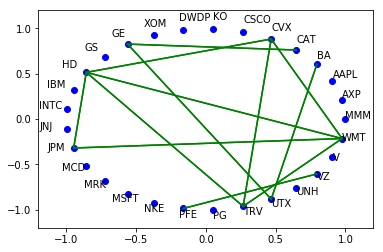

In [26]:
#Построение графа по одношаговой процедуре реальных данных
plot_graph(graph_pr_USA, ts_USA)

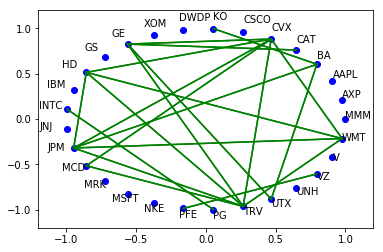

In [31]:
#Построение графа по процедуре Холма реальных данных
plot_graph(net_graph_pr_holm,ts_USA)

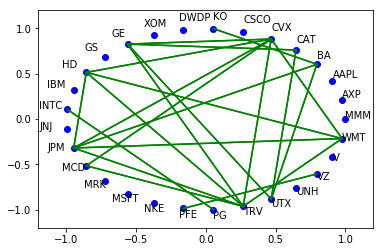

In [32]:
#Построение графа по процедуре Хочберга реальных данных
plot_graph(net_graph_pr_hochberg,ts_USA)

In [33]:
#Мера схожести графов по одношаговой и Холма
meassure_of_graph_similarity(graph_pr_USA,net_graph_pr_holm)

0.7272727272727273

In [34]:
#Мера схожести графов по одношаговой и Хочберга
meassure_of_graph_similarity(graph_pr_USA,net_graph_pr_hochberg)

0.7058823529411764

In [35]:
#Мера схожести графов по Холма и Хочберга
meassure_of_graph_similarity(net_graph_pr_hochberg,net_graph_pr_holm)

0.9767441860465117

In [27]:
#Описание данных для построения графа рынка по сгенерированным данным
N = len(data_USA)
c = np.cov(data_USA)
c = [c[i][i] for i in range(N)]
e = [E(data_USA[i]) for i in range(N)]
V = get_art_data(N, 0.3, e, c)
art_net_pr = gen_net(data=V, f=get_p_value)

In [36]:
art_graph_pr = gen_graph(net=art_net_pr, treshold=0.92)

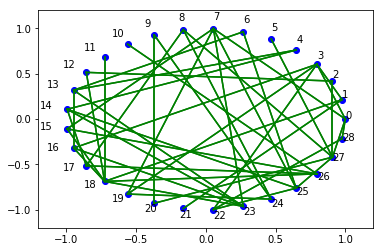

In [37]:
#Построение графа по одношаговой процедуре сгенерированных данных
plot_graph(graph=art_graph_pr,tickers=range(N))

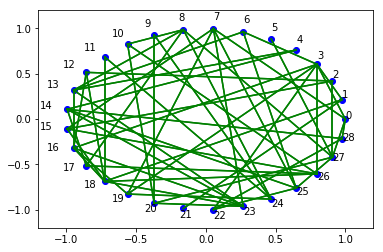

In [38]:
#Построение графа по процедуре Хочберга по сгенерированным данным
plot_graph(graph=art_graph_pr_hochberg,tickers=range(N))

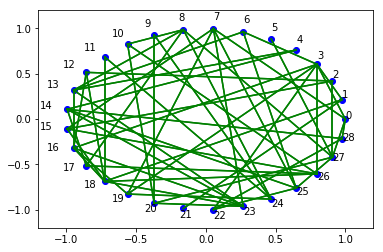

In [39]:
#Построение графа по процедуре Холма по сгенерированным данным
plot_graph(graph=art_graph_pr_holm,tickers=range(N))

In [40]:
#Мера схожести графов по одношаговой и Холма
meassure_of_graph_similarity(art_graph_pr,art_graph_pr_holm)

0.8932038834951457

In [41]:
#Мера схожести графов по одношаговой и Хочберга
meassure_of_graph_similarity(art_graph_pr,art_graph_pr_hochberg)

0.8932038834951457

In [42]:
#Мера схожести графов по Холма и Хочберга
meassure_of_graph_similarity(art_graph_pr_holm,art_graph_pr_hochberg)

1.0

In [30]:
art_graph_pr_holm = holm(art_net_pr, 0.05)
art_graph_pr_hochberg = hochberg(art_net_pr, 0.05)

net_graph_pr_holm = holm(net_pr_USA, 0.05)
net_graph_pr_hochberg = hochberg(net_pr_USA, 0.05)

In [43]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
ts_USA = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO',
          'KO','DWDP','XOM','GE','GS','HD','IBM','INTC',
          'JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG',
          'TRV','UTX','UNH','VZ','V','WMT','DIS']

start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2016, 6, 30)
table_USA  = get_data(ts_USA, start, end)

data_USA = table_USA.values
remove_empty_fields(data_USA)



N = len(data_USA)
c = np.cov(data_USA)
c = [c[i][i] for i in range(N)]
e = [E(data_USA[i]) for i in range(N)]


net_pr_USA = gen_net(data_USA, pr_corr)

In [44]:
def tmp():

    max_f_pr = 0
    max_g_pr = 0

    max_f_holm = 0
    max_g_holm = 0

    max_f_hochberg = 0
    max_g_hochberg = 0

    for g in np.arange(0.0,1,0.025):

        V = get_art_data(N, g, e, c)
        art_net = gen_net(data=V, f=get_p_value)

        art_graph_pr = gen_graph(net=art_net, treshold=0.9)
        art_graph_holm = holm(art_net, 0.05)
        art_graph_hochberg = hochberg(art_net, 0.05)

        nat_graph_pr = gen_graph(net=net_pr_USA, treshold=0.9)
        nat_graph_holm = holm(net_pr_USA, 0.05)
        nat_graph_hochberg = hochberg(net_pr_USA, 0.05)

        f_pr = meassure_of_graph_similarity(art_graph_pr, nat_graph_pr)
        f_holm = meassure_of_graph_similarity(art_graph_holm, nat_graph_holm)
        f_hochberg = meassure_of_graph_similarity(art_graph_hochberg, nat_graph_hochberg)

        if (f_pr > max_f_pr):
            max_f_pr = f_pr
            max_g_pr = g

        if (f_holm > max_f_holm):
            max_f_holm = f_holm
            max_g_holm = g

        if (f_hochberg > max_f_hochberg):
            max_f_hochberg = f_hochberg
            max_g_hochberg = g
    return max_f_pr, max_g_pr, max_f_holm, max_g_holm, max_f_hochberg, max_g_hochberg

In [41]:
#Оценка схожести реальных данных со сгенерированными, где 1 число- среднее мера схожести для определнной процедуры, 2-максимально 
#достигнутая схожесть для 100генераций данных,где на каждом g изменяетсмя с шагом 0,025, 3-наилучшее g по достигнутей схожести

k = 100

res = [tmp() for i in range(k)]

print sum([elem[0] for elem in res])/k
print max([elem[0] for elem in res])
print sum([elem[1] for elem in res])/k


print sum([elem[2] for elem in res])/k
print max([elem[2] for elem in res])
print sum([elem[3] for elem in res])/k

print sum([elem[4] for elem in res])/k
print max([elem[4] for elem in res])
print sum([elem[5] for elem in res])/k

0.17941668411
0.298507462687
0.54325
0.175248605411
0.307692307692
0.53075
0.178240079564
0.30303030303
0.56325
